# Transformada Hough

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import cv2
from scipy.signal import convolve

In [14]:
def hough_transform(img, angle_res=1., rho_res=1.):
    '''Calcula o acumulador da transformada Hough. Os parâmetros de entrada são uma imagem
       binária img, a resolução dos ângulos angle_res e a resolução da distância à origem
       rho_res. A função retorna, além do acumulador, os respectivos valores de ângulo e
       distâncias associados a cada posição do acumulador.'''
     
    num_rows, num_cols = img.shape
    center = np.array([num_rows//2, num_cols//2])   # Centro da imagem
     
    # Cria array de valores de ângulo, em radianos, no intervalo 
    # [-pi/2, pi/2] com passo de angle_res_rad
    angle_res_rad = angle_res*np.pi/180
    angle_values = np.arange(-np.pi/2, np.pi/2, angle_res_rad)
     
    # Consideraremos que a origem do espaço de parâmetros está no centro da imagem.
    # Com isso, o maior valor possível de rho é dado pela distância do centro da imagem
    # ao canto esquerdo superior
    max_rho = int(np.ceil(np.sqrt(center[0]**2+center[1]**2)))
    
    # Note que a coordenada rho pode ser negativa, então os valores possíveis de rho vão de 
    # -max_rho a max_rho
    rho_values = np.arange(-max_rho, max_rho+rho_res, rho_res)
     
    h_acc = np.zeros((len(rho_values), len(angle_values)))
 
    angle_indices = range(len(angle_values))
    for row in range(num_rows):
        for col in range(num_cols):
            if img[row, col]==1:
                # Utilizamos numpy para calcular os valores de rho para todos os ângulos.
                # rho_arr é um array de mesmo tamanho que angles
                rho_arr = (row-center[0])*np.sin(angle_values) + \
                                        (col-center[1])*np.cos(angle_values)

                # Para somarmos os valores no acumulador, precisamos transformar rho_arr, que
                # é um array de valores float no intervalo [-max_rho, max_rho], para um array de
                # valores inteiros no intervalo [0, num_rho_values-1]
                rho_norm = (max_rho+rho_arr)/rho_res
                rho_ind = np.floor(rho_norm).astype(int)

                # Para cada ângulo e distância rho encontrados, soma 1 no acumulador
                h_acc[rho_ind, angle_indices] += 1
                    
    return h_acc, angle_values, rho_values

### Leitura da imagem

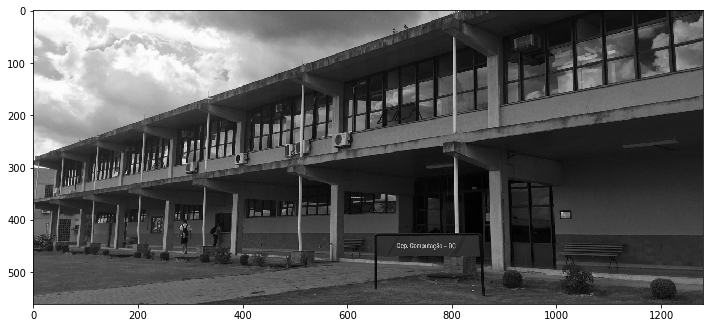

In [15]:
img_color = plt.imread('fachada_dc.jpg')
img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
img_gray = img_gray.astype(float)

plt.figure(figsize=[12,12])
plt.imshow(img_gray, 'gray')

### Cálculo da magnitude do gradiente para detecção de bordas

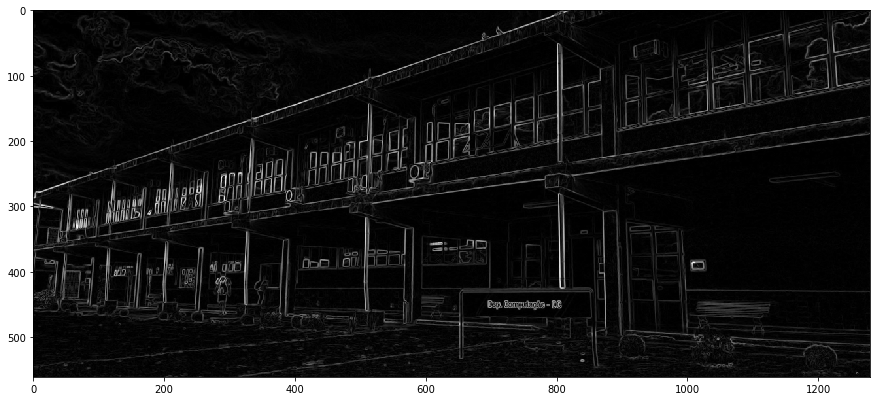

In [16]:
def gradient_magnitude(img, sigma):
    '''Calcula a magnitude do gradiente para cada pixel da imagem. sigma ajusta
       a quantidade de suavização gaussiana a ser aplicada.'''
    
    sobel_filter = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    # Normaliza filtro para que a soma dos valores absolutos seja 1
    sobel_filter = sobel_filter/8.   

    # Adiciona pixels ao redor da imagem para eliminar descontinuidade da 
    # derivada. mode='edge' significa que o valor de cada pixel adicionado
    # será igual ao valor do pixel mais próximo conhecido.
    img_pad = np.pad(img, 1, mode='edge')
    
    # Suaviza imagem e deriva. mode='nearest' tem o mesmo significado 
    # que mode='edge' utilizado acima
    img_smooth = ndi.gaussian_filter(img_pad, sigma=sigma, mode='nearest')
    img_x_derivative = convolve(img_smooth, sobel_filter, 
                                mode='same')
    img_y_derivative = convolve(img_smooth, sobel_filter.transpose(), 
                                mode='same')
    
    img_gradient_magnitude_pad = np.sqrt(img_x_derivative**2 + 
                                         img_y_derivative**2)
    
    # Recupera região da imagem sem o pad
    img_gradient_magnitude = img_gradient_magnitude_pad[1:-1, 1:-1]

    return img_gradient_magnitude

img_gradient_magnitude = gradient_magnitude(img_gray, 0.5)
# A função acima faz um procedimento similar à função do scipy abaixo
#img_gradient_magnitude = ndi.gaussian_gradient_magnitude(img_gray, sigma=0.7, 
#                                                         mode='nearest')

plt.figure(figsize=[15,15])
plt.imshow(img_gradient_magnitude, 'gray')

### Limiarização da magnitude do gradiente

Abaixo poderíamos ter utilizado um método de seleção automática de limiar (ex: Otsu), mas para simplificar vamos definir um valor fixo.

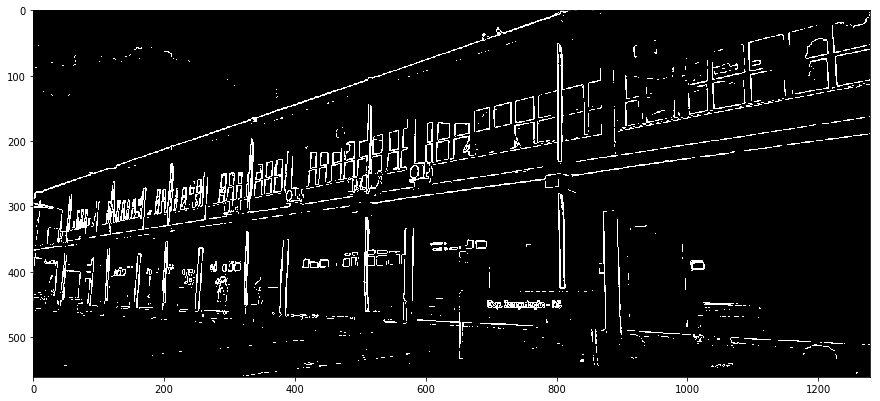

In [17]:
img_edges = img_gradient_magnitude>20
plt.figure(figsize=[15,15])
plt.imshow(img_edges, 'gray')

### Cálculo e visualização da transformada Hough

Poderíamos utilizar a função plt.imshow() para a visualização, mas o array h_acc possui muito mais linhas do que colunas, e com isso a visualização seria uma imagem muito comprida. A função pcolormesh utiliza pixels que não são necessariamente quadrados, de forma que o resultado fica mais fácil de visualizar.

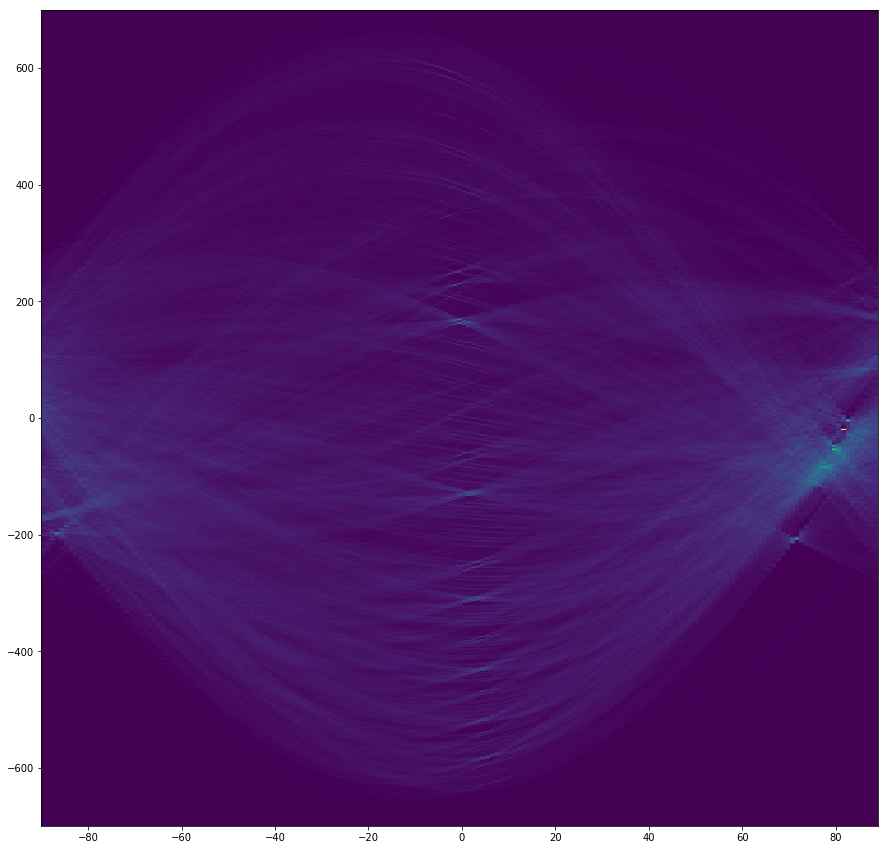

In [18]:
h_acc, angle_values, rho_values = hough_transform(img_edges, angle_res=0.99, 
                                            rho_res=1.)
angles_degrees = 180*angle_values/np.pi
plt.figure(figsize=[15,15])
plt.pcolormesh(angles_degrees, rho_values, h_acc)

### Encontra picos no acumulador da transformada Hough

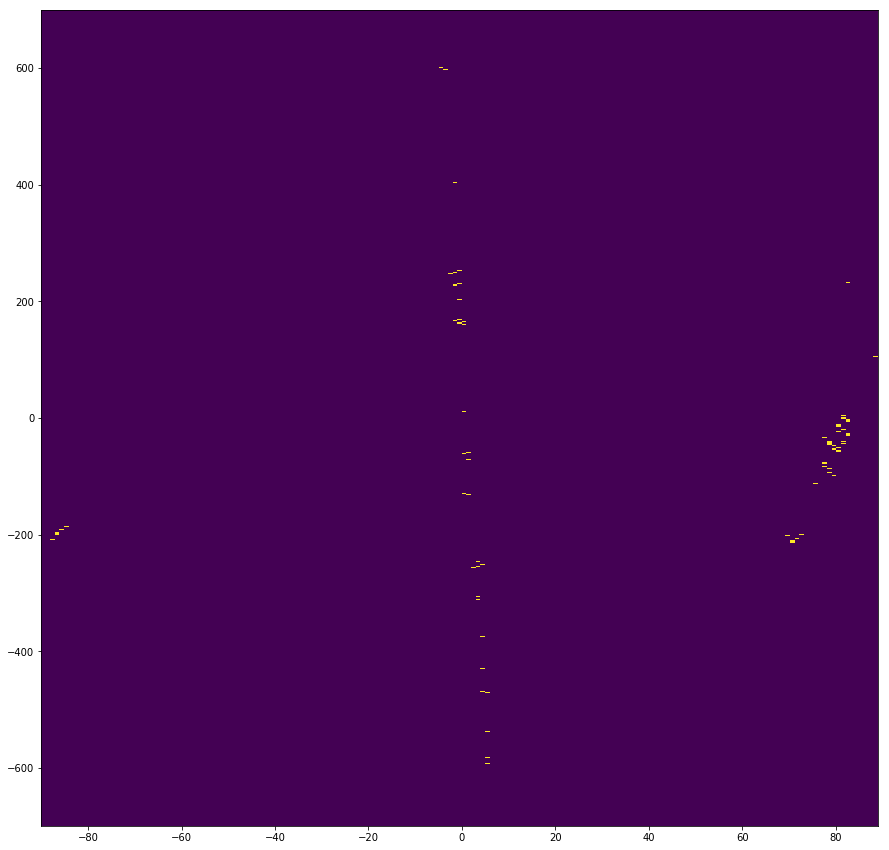

In [19]:
def find_peaks_2d(h_acc, threshold):
    '''Encontra picos no array h_acc. O método utilizado é aplicar um filtro uniforme 
       em h_acc e verificar a diferença entre o resultado e h_acc. Picos relevantes 
       tenderão a apresentar alta diferença após a suavização.'''
    
    h_acc_avg = ndi.uniform_filter(h_acc, 3)
    h_diff = h_acc-h_acc_avg
    img_peaks = h_diff>threshold

    return img_peaks

img_peaks = find_peaks_2d(h_acc, 50)
plt.figure(figsize=[15,15])
plt.pcolormesh(angles_degrees, rho_values, img_peaks)

### Definição da posição dos picos

Os picos calculados são, em geral, componentes conexos possuindo mais de 1 pixel. Portanto, precisamos calcular o centróide de cada pico para termos apenas 1 ponto associado.

In [20]:
# img_lab possui os componentes conexos de img_peaks, e num_comp o número de componentes
img_lab, num_comp = ndi.label(img_peaks)         

# peaks é uma lista de pontos, cada ponto representa um pico no acumulador
peaks = ndi.center_of_mass(img_peaks, img_lab, range(1, num_comp+1))

# Definição de uma lista possuindo os valores de ângulo e distância rho associada
# com cada pico encontrado
lines = []
for point in peaks:
    rho = rho_values[int(point[0])]
    angle = angle_values[int(point[1])]
    lines.append((rho, angle))

### Desenho das retas encontradas

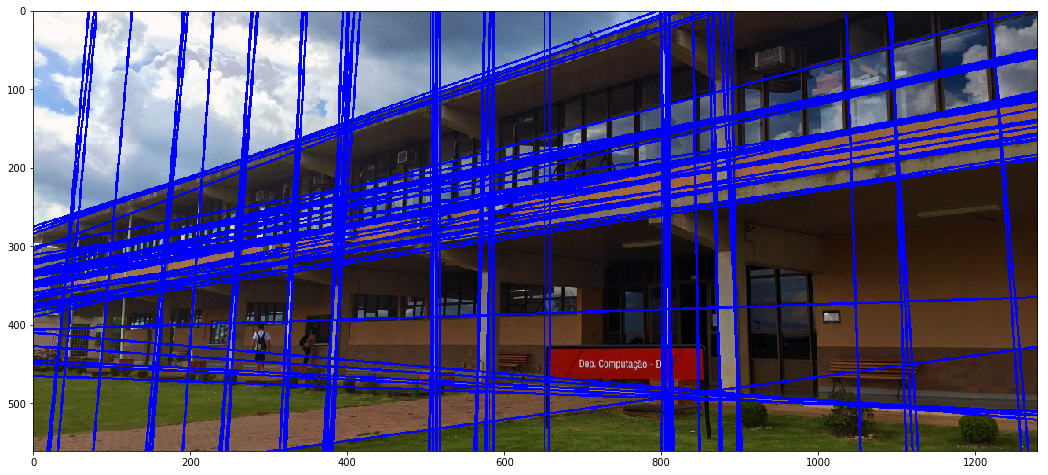

In [21]:
def draw_lines(lines, img):
    '''Desenha as retas descritas pelos parâmetros theta e rho contidos na lista lines.
       O desenho é feito sobre uma cópia da imagem img'''
    
    img_draw = img.copy()
    num_rows, num_cols = img.shape[:2]
    center = np.array([num_rows//2, num_cols//2])
    min_x = -num_cols//2
    max_x = num_cols//2
    for line in lines:
        rho, theta = line
        cost = np.cos(theta)
        sint = np.sin(theta)
        # Trata o caso específico no qual sen(theta)==0
        if sint==0:
            x1 = x2 = rho/cost
            y1 = 0
            y2 = img.shape[0]
        else:
            x1 = min_x
            x2 = max_x
            y1 = int((rho-min_x*cost)/sint)
            y2 = int((rho-max_x*cost)/sint)

        x1 = min_x + center[1]
        x2 = max_x + center[1]
        y1 = y1 + center[0]
        y2 = y2 + center[0]
        cv2.line(img_draw,(x1,y1),(x2,y2),(0,0,255),2)
        
    return img_draw
   
img_draw = draw_lines(lines, img_color)
plt.figure(figsize=[18,18])
plt.imshow(img_draw, 'gray')